<a href="https://colab.research.google.com/github/ducodbs0516/pdm18/blob/main/py-tensorflow/pdm18_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **transfer learning(TL) 이란**
- transfer learning 이란 입력층에 가까운 부분의 결합 파라미터는 학습된 값으로 변화시키지 않고 
학습된 모델을 기반으로 최종 출력층을 바꿔가며 학습 하는 것 입니다. 
학습된 모델의 최종 출력층을 보유 중인 데이터에 대응하는 출력층으로 바꾸고
교체한 출력층의 결합 파라미터를 소량의 데이터로 다시 학습합니다.

# **cifar10에 대한 TL 결과 요약**

- 먼저 Keras를 사용하여 데이터 세트를 다운로드해주고 기존에 50000개의 train data를
10%인 5000개로 변형해줍니다.

- Naming the classes 를 해주어 One-Hot Encoding에서 사용될 클래스의 개수를 선언해주고
cifar10이 가지고 있는 데이터의 이름을 나열해줍니다.

- 그리고 Loss의 스케일 조정을 위해  astype('float32')코드를 통해 실수화(float)된 후 255으로 나누어 주어 
0 ~ 255 -> 0 ~ 1 범위로 만들어주고 평균과 표준편차를 구하여 정규화 작업을 합니다.

- One-Hot Encoding으로 숫자를 One-Hot Vector로 변형하여 클래스 벡터를 0에서 10의 정수 벡터로 바꾸어 줍니다.

- 훈련 데이터 수가 별로 없기 때문에 Data augmentation 방법을 해주어 데이터를 확장해줍니다.
20도 이내에서 회전, 좌우 반전 , 가로와 세로 방향 20% 범위에서 이동이 가능한 변화를 주도록 설정하였습니다.

- Keras으로 부터 MobileNetV2 를 사용하여 전이 학습을 수행합니다.
데이터의 개수가 작기 때문에 pre-trained된 모델을 이미지에 적용해줍니다. 

- 사용한 옵티마이저는 adam이고 학습률을 다양하게 번갈아가며 학습해주어 경험상 가장 좋은 결과를 보인것은
1e-4였습니다. patience을 조절하여 학습할 시간을 많이 주려고 노력했고 오버피팅을 막기 위해 다양한 결과를 내며 결과를 비교하였습니다. 
epochs=500, batch size= 64로 이미지 사이즈를 32, 64, 128로 바꾸어 가며 좋은 결과를 내도록 노력하였습니다.

- 모델의 손실도와 정확도를 계산하고 confusion matrix로 시각화하여 결과를 확인하였습니다. 
training and validation accuracy는 0.701이었습니다. 

- 다음으로 fine tuning을 통해 출력층 및 모든 층의 파라미터를 다시 학습하였습니다. 
fine tuning training and validation accuracy는 0.793으로 정확도가 오르는 결과를 보았고 
confusion matrix로 시각화하여 결과를 보니 fine tuning 전보다 오답률이 떨어지는 것을 확인할 수 있었습니다.

- 다양한 시도를 하여 더 좋은 결과를 얻기 위해 다양한 모델을 사용하여 결과를 내보고, data augmentation에서 
이미지 회전, 이동, 확대/축소, 수평 뒤집기 등 다양하게 시도하여 더 좋을 결과를 내도록 노력할것입니다.




# ConvNet: MobileNetV2

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


## Load data 
- Use 10% cifar10 data

In [ ]:
# loading data
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# 10% cifar data using 
x_train = x_train[:5000]
y_train0 = y_train0[:5000]

print(x_train.shape[0], 'x_train samples')
print(y_train0.shape[0], 'y_train samples')

5000 x_train samples
5000 y_train samples


- class labels

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# **Preprocess the dataset**

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [ ]:
x_train = preprocess_image_input(x_train)
x_test = preprocess_image_input(x_test)

In [ ]:
# mean-std normalization

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

## **Convert class vectors to binary class matrices**

In [ ]:
from keras.utils import np_utils

y_train = keras.utils.to_categorical(y_train0, 10)
y_test = keras.utils.to_categorical(y_test0, 10 )

## **data augumatation**


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False, 
        featurewise_std_normalization=False, 
        rotation_range=25,
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        vertical_flip=False,
        horizontal_flip=True)
datagen.fit(x_train)

---

# **Define the Network**
- MobileNetV2

In [ ]:
#중요
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs): #사진에서 특징 뽑아내는 함수 - cnn단계에서

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
  #   Unfreeze top layers for fine tuning
  TL_base.trainable = False 
  return TL_base(inputs)


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs): #파라미터 train 시킴
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x) #벡터로 변환
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs): #output을 만들어줌

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs) #input 데이터 받아 7배씩 확장 후 224*224로 바꿈

    resnet_feature_extractor = feature_extractor(resize) #바꾼 영상 넣어 특징 뽑아냄
    classification_output = classifier(resnet_feature_extractor) #10개 보여주는 3층 fcn으로 보내 output 만들어냄

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model(): #모델 구성
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) #input, output까지 모두 구성
  model = tf.keras.Model(inputs=inputs, outputs = classification_output) #모델 생성
  
  #모델 계산과정 지정
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# data augmentation
# https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=25,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [ ]:
opt_adam = keras.optimizers.Adam(learning_rate=0.001, decay = 1e-6)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./2/cifar10_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=15)    # patience=10, 25, 50

## **Train the model**

In [ ]:
%%time
EPOCHS = 500
BATCH_SIZE = 64  # 32, 50, 64, 100
history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 1/500
79/79 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.6096

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


79/79 [==============================] - 38s 481ms/step - loss: 1.1029 - accuracy: 0.6096 - val_loss: 1.0541 - val_accuracy: 0.6232
Epoch 2/500
79/79 [==============================] - 36s 456ms/step - loss: 0.8399 - accuracy: 0.7004 - val_loss: 0.9645 - val_accuracy: 0.6607
Epoch 3/500
79/79 [==============================] - 35s 451ms/step - loss: 0.7209 - accuracy: 0.7422 - val_loss: 1.0508 - val_accuracy: 0.6365
Epoch 4/500
79/79 [==============================] - 36s 455ms/step - loss: 0.6184 - accuracy: 0.7776 - val_loss: 0.9334 - val_accuracy: 0.6882
Epoch 5/500
79/79 [==============================] - 35s 450ms/step - loss: 0.5234 - accuracy: 0.8108 - val_loss: 1.0456 - val_accuracy: 0.6561
Epoch 6/500
79/79 [==============================] - 35s 450ms/step - loss: 0.4430 - accuracy: 0.8422 - val_loss: 1.0222 - val_accuracy: 0.6786
Epoch 7/500
79/79 [==============================] - 35s 450ms/step - loss: 0.3540 - accuracy: 0.8696 - val_loss: 1.1100 - val_accuracy: 0.6729
Epoc

##**Evaluate the Model**

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

157/157 [==============================] - 24s 152ms/step - loss: 2.4384 - accuracy: 0.6997


[2.438408613204956, 0.6996999979019165]

## 훈련 데이터와 검증 데이터에 대한 loss, accuracy 시각화

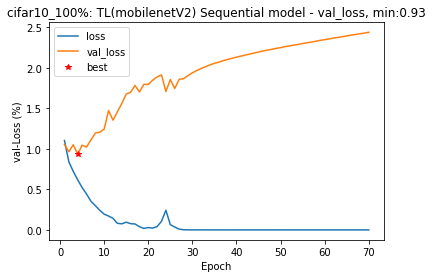

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

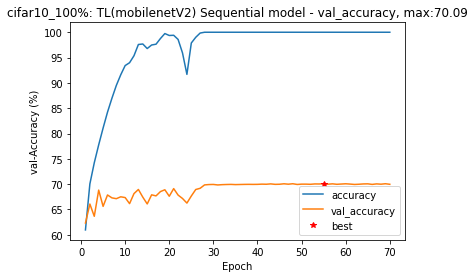

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

### Visualization loss & accuracy

The training/validation loss and accuracy visualizations are shown below

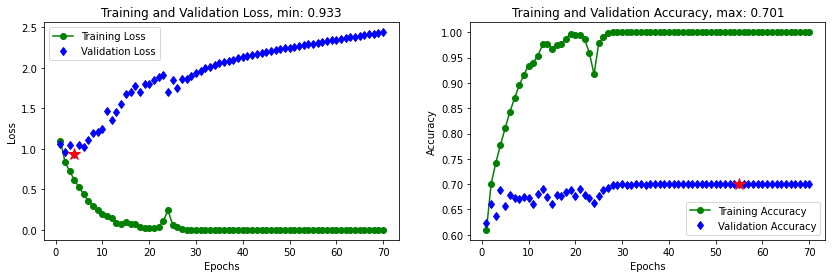

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **best model evaluate**

In [ ]:
from keras.models import load_model

model_best = load_model('./2/cifar10_c2f3_best_weights.055-0.7009.hdf5')
model_best.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

313/313 [==============================] - 26s 81ms/step - loss: 3.0421 - accuracy: 0.6654


[3.0421369075775146, 0.6654000282287598]

# **confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)

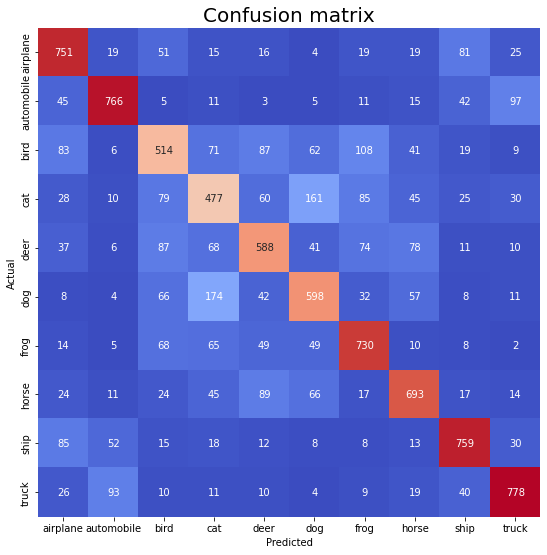

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

---

# **Fine tuning**

In [ ]:
tf.keras.backend.clear_session()  # For memory

In [ ]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
#주의
def feature_extractor_fine_tuning(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
#   Unfreeze top layers for fine tuning
  TL_base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 107

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in TL_base.layers[:fine_tune_at]:
    layer.trainable =  False #107 전까지 고정된 값 이용

  return TL_base(inputs)

def final_model_ft(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    fine_feature_extractor = feature_extractor_fine_tuning(resize) #주의
    classification_output = classifier(fine_feature_extractor)

    return classification_output

def define_compile_model_ft():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_ft(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model

model = define_compile_model_ft()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

In [ ]:
opt_adam = keras.optimizers.Adam(learning_rate=0.001, decay = 1e-6)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./fine2/20193278_yeochaeyun/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=50)

## **Train the fine-tuned model**

In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 500
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
%%time
BATCH_SIZE = 64  # 32, 50, 64, 100
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 71/570
79/79 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.6478

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


79/79 [==============================] - 46s 528ms/step - loss: 1.0539 - accuracy: 0.6478 - val_loss: 5.8871 - val_accuracy: 0.3192
Epoch 72/570
79/79 [==============================] - 40s 512ms/step - loss: 0.5574 - accuracy: 0.8124 - val_loss: 6.5812 - val_accuracy: 0.3853
Epoch 73/570
79/79 [==============================] - 40s 512ms/step - loss: 0.3896 - accuracy: 0.8746 - val_loss: 5.5066 - val_accuracy: 0.4264
Epoch 74/570
79/79 [==============================] - 40s 506ms/step - loss: 0.2925 - accuracy: 0.9074 - val_loss: 5.5365 - val_accuracy: 0.3214
Epoch 75/570
79/79 [==============================] - 40s 506ms/step - loss: 0.2391 - accuracy: 0.9234 - val_loss: 4.1319 - val_accuracy: 0.3810
Epoch 76/570
79/79 [==============================] - 58s 735ms/step - loss: 0.1636 - accuracy: 0.9486 - val_loss: 8.6416 - val_accuracy: 0.2360
Epoch 77/570
79/79 [==============================] - 40s 508ms/step - loss: 0.1991 - accuracy: 0.9366 - val_loss: 12.7252 - val_accuracy: 0.20

## **Evaluate the Model**

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

157/157 [==============================] - 24s 153ms/step - loss: 1.9448 - accuracy: 0.7504


[1.9447869062423706, 0.7504000067710876]

### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

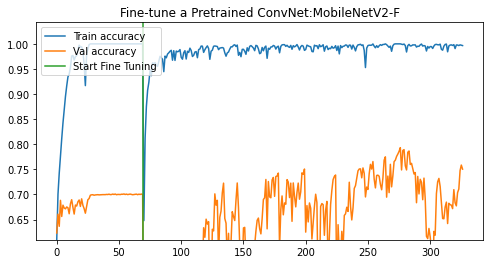

In [ ]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-F")
plt.legend(loc='upper left')

plt.show()

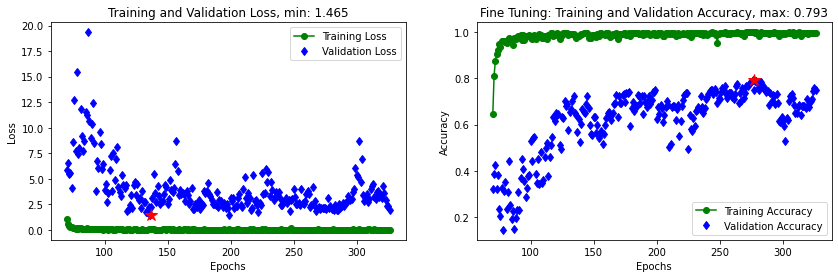

In [ ]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model
- cifar10pct100_mobileNetV2F_SGD_FT_best_weights.277-0.793.hdf5

In [ ]:
from keras.models import load_model

model_best = load_model('/content/fine2/20193278_yeochaeyun/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.277-0.793.hdf5')
model_best.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

157/157 [==============================] - 25s 154ms/step - loss: 2.0511 - accuracy: 0.7932


[2.051088333129883, 0.7932000160217285]

# **confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test0, predictions0)

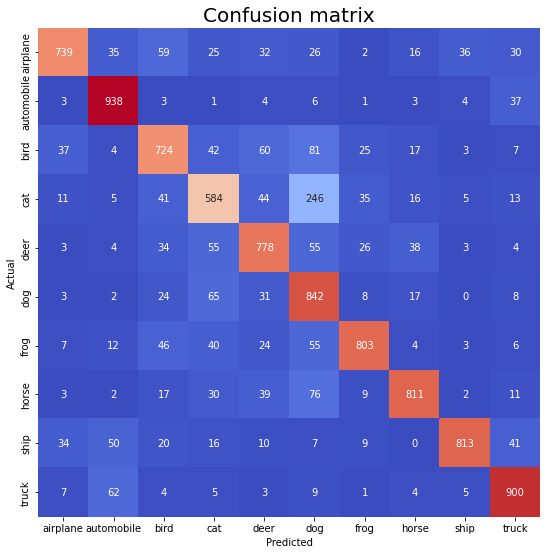

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=classes, yticklabels=classes, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()

---

---